In [1]:
import numpy as np
import tensorflow as tf
import time
import logging
from tensorflow import keras
import json 
import pathlib
import matplotlib.pyplot as plt
import os 
import pandas as pd
from scipy.optimize import root

## Test Intra-temporal FOC

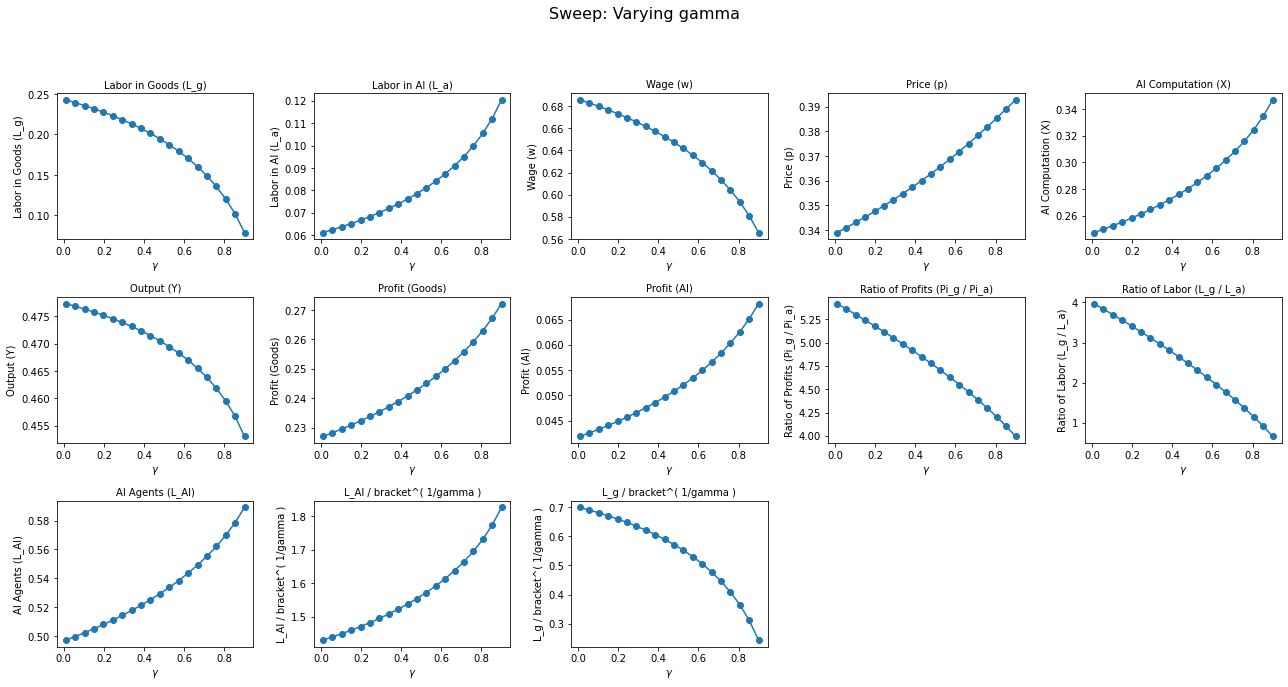

<ipython-input-10-34d795f3b92d>:21: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (L_a ** (1 - alpha))
<ipython-input-10-34d795f3b92d>:42: RuntimeWarning: invalid value encountered in scalar power
  p_AI = (w / (Z * (1 - alpha))) * (L_a ** alpha)


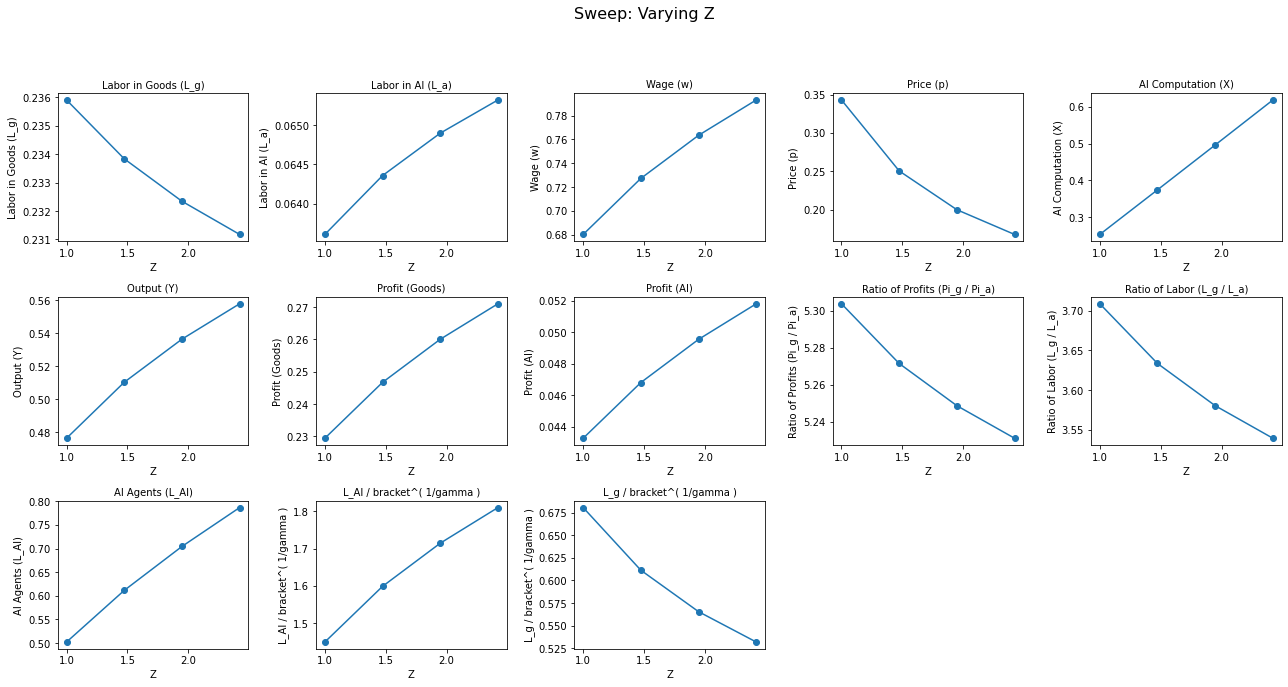

<ipython-input-10-34d795f3b92d>:21: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (L_a ** (1 - alpha))
<ipython-input-10-34d795f3b92d>:42: RuntimeWarning: invalid value encountered in scalar power
  p_AI = (w / (Z * (1 - alpha))) * (L_a ** alpha)


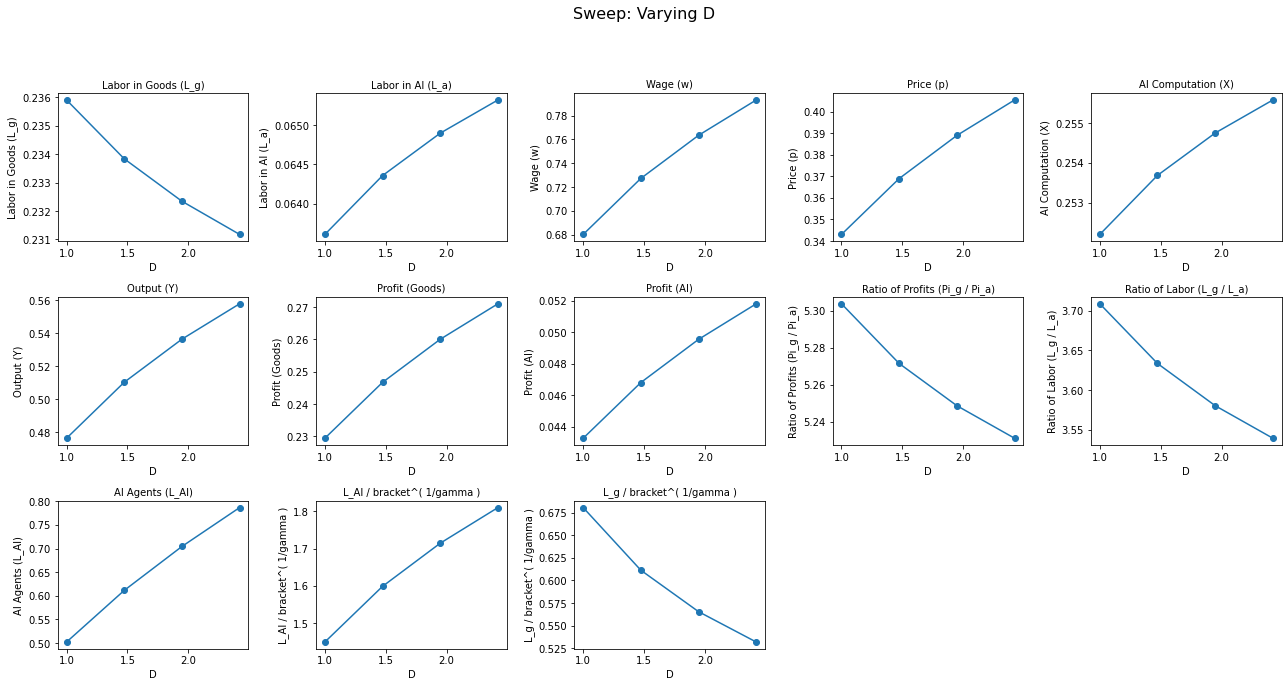

In [10]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

##############################################################################
# 1) Static AI Model: Definitions & Solver
##############################################################################

def ai_equations(vars_, A_g, iota, gamma, beta, alpha, theta, Z, D, psi):
    """
    Returns the residuals of the system of equations in unknowns (L_g, L_a, w):
      (1) FOC wrt L_g => MP(L_g) - w = 0
      (2) Price consistency => p from AI sector = p from general goods
      (3) Labor supply => 1 - L_g - L_a - psi*(Y/w) = 0

    We assume K_a = K_g = 1 in this static model. 
    """
    L_g, L_a, w = vars_

    # AI Sector Output: X = Z * L_a^(1-alpha)
    X = Z * (L_a ** (1 - alpha))

    # AI "Effective Labor": L_AI = D^theta * X^(1 - theta)
    L_AI = (D ** theta) * (X ** (1 - theta))

    # "Bracket" in General Goods Sector
    bracket = iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)

    # Output in General Goods Sector: Y = A_g * bracket^((1-beta)/gamma)
    Y = A_g * (bracket ** ((1 - beta) / gamma))

    # (1) FOC wrt L_g => MP_Lg = w
    MP_Lg = (
        A_g * (1 - beta) * iota
        * bracket ** (((1 - beta) / gamma) - 1)
        * (L_g ** (gamma - 1))
    )
    eq1 = MP_Lg - w

    # (2) Price Consistency
    # AI sector: p_AI = w / [Z*(1-alpha)] * L_a^alpha
    p_AI = (w / (Z * (1 - alpha))) * (L_a ** alpha)

    # General goods sector FOC wrt X => p_G
    p_G = (
        A_g * (1 - beta) * (1 - iota)
        * bracket ** (((1 - beta) / gamma) - 1)
        * (L_AI ** (gamma - 1))
        * (1 - theta) * (D ** theta) * (X ** (-theta))
    )
    eq2 = p_AI - p_G

    # (3) Labor supply => 1 = L_g + L_a + psi*(Y / w)
    eq3 = 1.0 - L_g - L_a - psi * (Y / w)

    return np.array([eq1, eq2, eq3])


def solve_ai_model(
    alpha=0.5,   # exponent in AI sector
    theta=0.5,   # exponent for data in forming AI-labor
    gamma=0.1,   # elasticity of substitution between L_g and L_AI
    iota=0.85,   # weight on L_g vs L_AI in bracket
    beta=0.3,    # exponent for capital in general goods
    psi=1.0,     # leisure param: N = psi*(Y/w)
    A_g=1,    # TFP in general goods
    Z=1.0,       # AI sector productivity
    D=1.0,       # data
    guess=(0.3, 0.3, 1.0),
    method='hybr'
):
    """
    Solve the static model for (L_g, L_a, w). 
    Then compute derived variables: p, X, L_AI, Y, N, Pi_g, Pi_a.

    Returns a dict of equilibrium values.
    """
    sol = root(
        ai_equations,
        guess,
        args=(A_g, iota, gamma, beta, alpha, theta, Z, D, psi),
        method=method
    )
    if not sol.success:
        raise RuntimeError(f"Solve failed: {sol.message}")
    
    L_g, L_a, w = sol.x

    # Recompute all interesting variables
    X = Z * (L_a ** (1 - alpha))
    L_AI = (D ** theta) * (X ** (1 - theta))
    bracket = iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)
    Y = A_g * (bracket ** ((1 - beta) / gamma))
    p = (w / (Z * (1 - alpha))) * (L_a ** alpha)
    # N by definition: 1 - L_g - L_a (though also = psi*(Y/w) in equilibrium)
    N = 1.0 - L_g - L_a

    # Profits
    Pi_g = Y - w * L_g - p * X
    Pi_a = p * X - w * L_a
    
    return {
        'L_g': L_g,
        'L_a': L_a,
        'w': w,
        'p': p,
        'X': X,
        'L_AI': L_AI,
        'Y': Y,
        'N': N,
        'Pi_g': Pi_g,
        'Pi_a': Pi_a,
    }


##############################################################################
# 2) Parameter sweep + storing of *ALL* variables plus the new ratios
##############################################################################

def run_sweep(param_name, values, fixed_params):
    """
    For each value in 'values' (for param_name), solve the model and
    store all relevant variables plus the 'new' ratio variables:

      ratio_of_profits = Pi_g / Pi_a
      ratio_of_labors  = L_g / L_a
      ratio_LAI        = L_AI / bracket^{(1-beta)/gamma}
      ratio_Lg         = L_g  / bracket^{(1-beta)/gamma}

    Returns a dictionary of numpy arrays, each length = len(values).
    """
    # We'll store all main equilibrium variables plus the new ratios
    all_keys = [
        'L_g', 'L_a', 'w', 'p', 'X', 'Y', 'Pi_g', 'Pi_a',
        'L_AI', 'N',
        'ratio_of_profits',
        'ratio_of_labors',
        'ratio_LAI',
        'ratio_Lg'
    ]
    storage = {k: [] for k in all_keys}

    for val in values:
        # 1) Copy base params
        p_ = dict(fixed_params)
        p_[param_name] = val

        # 2) Attempt solve
        try:
            eq = solve_ai_model(**p_)
        except Exception:
            # If failure, store nan
            for k in all_keys:
                storage[k].append(np.nan)
            continue

        # 3) Calculate new ratio variables
        gamma_ = p_['gamma']
        beta_  = p_['beta']
        iota_  = p_['iota']

        bracket_val = iota_ * (eq['L_g'] ** gamma_) + (1 - iota_)*(eq['L_AI'] ** gamma_) \
                      if (not np.isnan(eq['L_g'])) else np.nan
        if bracket_val > 0:
            denom = bracket_val ** (1 / gamma_)
        else:
            denom = np.nan

        if eq['Pi_a'] != 0:
            ratio_of_profits = eq['Pi_g'] / eq['Pi_a']
        else:
            ratio_of_profits = np.nan

        ratio_of_labors = eq['L_g']/eq['L_a'] if eq['L_a'] != 0 else np.nan
        ratio_LAI = eq['L_AI']/denom if denom != 0 else np.nan
        ratio_Lg  = eq['L_g']/denom   if denom != 0 else np.nan

        # 4) Store everything
        storage['L_g'].append(eq['L_g'])
        storage['L_a'].append(eq['L_a'])
        storage['w'].append(eq['w'])
        storage['p'].append(eq['p'])
        storage['X'].append(eq['X'])
        storage['Y'].append(eq['Y'])
        storage['Pi_g'].append(eq['Pi_g'])
        storage['Pi_a'].append(eq['Pi_a'])
        storage['L_AI'].append(eq['L_AI'])
        storage['N'].append(eq['N'])
        storage['ratio_of_profits'].append(ratio_of_profits)
        storage['ratio_of_labors'].append(ratio_of_labors)
        storage['ratio_LAI'].append(ratio_LAI)
        storage['ratio_Lg'].append(ratio_Lg)

    # Convert to numpy arrays
    for k in storage:
        storage[k] = np.array(storage[k], dtype=float)

    return storage


##############################################################################
# 3) Plot function: 13 subplots in 1 big figure (no .grid)
##############################################################################

def plot_sweep_subplots(x_vals, results, x_label, title_prefix):
    """
    Create a single figure with subplots. We show 13 variables:

      1.  L_g
      2.  L_a
      3.  w
      4.  p
      5.  X
      6.  Y
      7.  Pi_g
      8.  Pi_a
      9.  ratio_of_profits
      10. ratio_of_labors
      11. L_AI
      12. ratio_LAI
      13. ratio_Lg

    We'll layout a 3x5 = 15 subplot grid and hide the last 2.
    """
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    fig.suptitle(f"{title_prefix}", fontsize=16)

    # We'll define an ordered list of (key, label) to place them in subplots row by row
    # We'll fill 13 subplots (the 14th and 15th we can hide).
    plot_list = [
        ('L_g',            "Labor in Goods (L_g)"),
        ('L_a',            "Labor in AI (L_a)"),
        ('w',              "Wage (w)"),
        ('p',              "Price (p)"),
        ('X',              "AI Computation (X)"),
        ('Y',              "Output (Y)"),
        ('Pi_g',           "Profit (Goods)"),
        ('Pi_a',           "Profit (AI)"),
        ('ratio_of_profits',"Ratio of Profits (Pi_g / Pi_a)"),
        ('ratio_of_labors',"Ratio of Labor (L_g / L_a)"),
        ('L_AI',           "AI Agents (L_AI)"),
        ('ratio_LAI',      "L_AI / bracket^( 1/gamma )"),
        ('ratio_Lg',       "L_g / bracket^( 1/gamma )"),
    ]

    # We have 3 rows x 5 cols => 15 subplots; fill first 13.
    idx = 0
    for row in range(3):
        for col in range(5):
            if idx < len(plot_list):
                key, ylabel = plot_list[idx]
                ax = axes[row, col]
                ax.plot(x_vals, results[key], 'o-')
                ax.set_xlabel(x_label)
                ax.set_ylabel(ylabel)
                ax.set_title(ylabel, fontsize=10)
                # No grid
                idx += 1
            else:
                # Hide remaining subplots (the last 2 if any left)
                axes[row,col].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


##############################################################################
# 4) MAIN:  Sweeps for gamma, Z, D.  Each produces a single big figure.
##############################################################################

if __name__ == "__main__":
    # Base parameters
    base_params = {
        'alpha': 0.5,
        'theta': 0.5,
        'gamma': 0.1,
        'iota': 0.5,
        'beta': 0.3,
        'psi': 1.0,
        'A_g': 1.0,
        'Z': 1.0,
        'D': 1.0,
        'guess': (0.3, 0.3, 1.0)
    }

    # 1) Sweep gamma from 0.01 to 1.0
    gamma_vals = np.linspace(0.01, 0.9, 20)
    res_gamma = run_sweep('gamma', gamma_vals, base_params)
    plot_sweep_subplots(gamma_vals, res_gamma, r"$\gamma$", "Sweep: Varying gamma")

    # 2) Sweep Z from 1.0 to 10.0
    Z_vals = np.linspace(1.0, 10.0, 20)
    res_Z = run_sweep('Z', Z_vals, base_params)
    plot_sweep_subplots(Z_vals, res_Z, "Z", "Sweep: Varying Z")

    # 3) Sweep D from 1.0 to 10.0
    D_vals = np.linspace(1.0, 10.0, 20)
    res_D = run_sweep('D', D_vals, base_params)
    plot_sweep_subplots(D_vals, res_D, "D", "Sweep: Varying D")

<ipython-input-14-f28d08a08f6d>:40: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


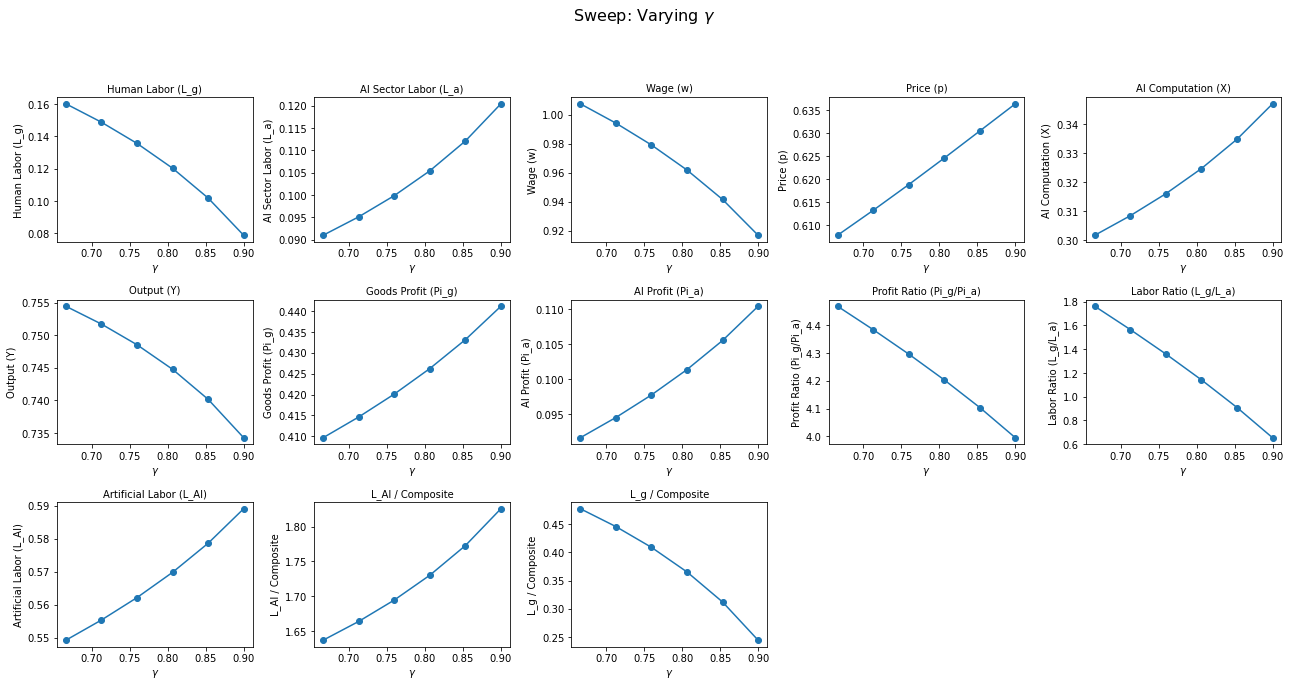

<ipython-input-14-f28d08a08f6d>:40: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


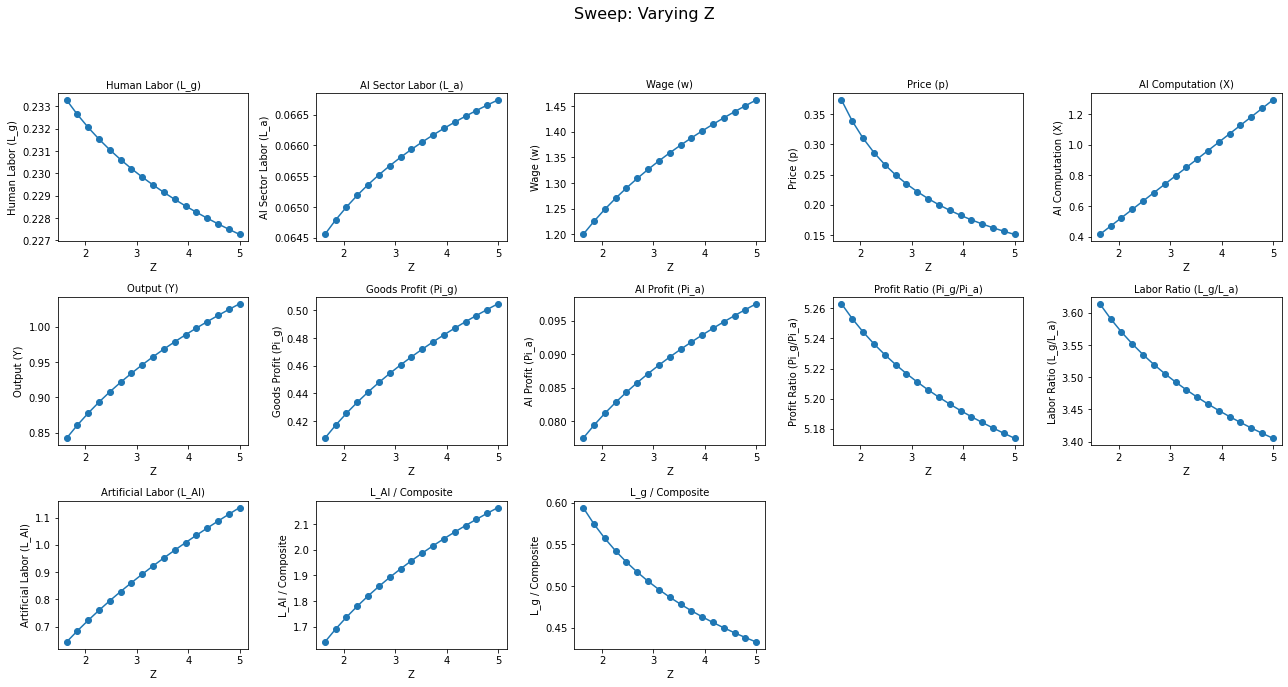

<ipython-input-14-f28d08a08f6d>:40: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


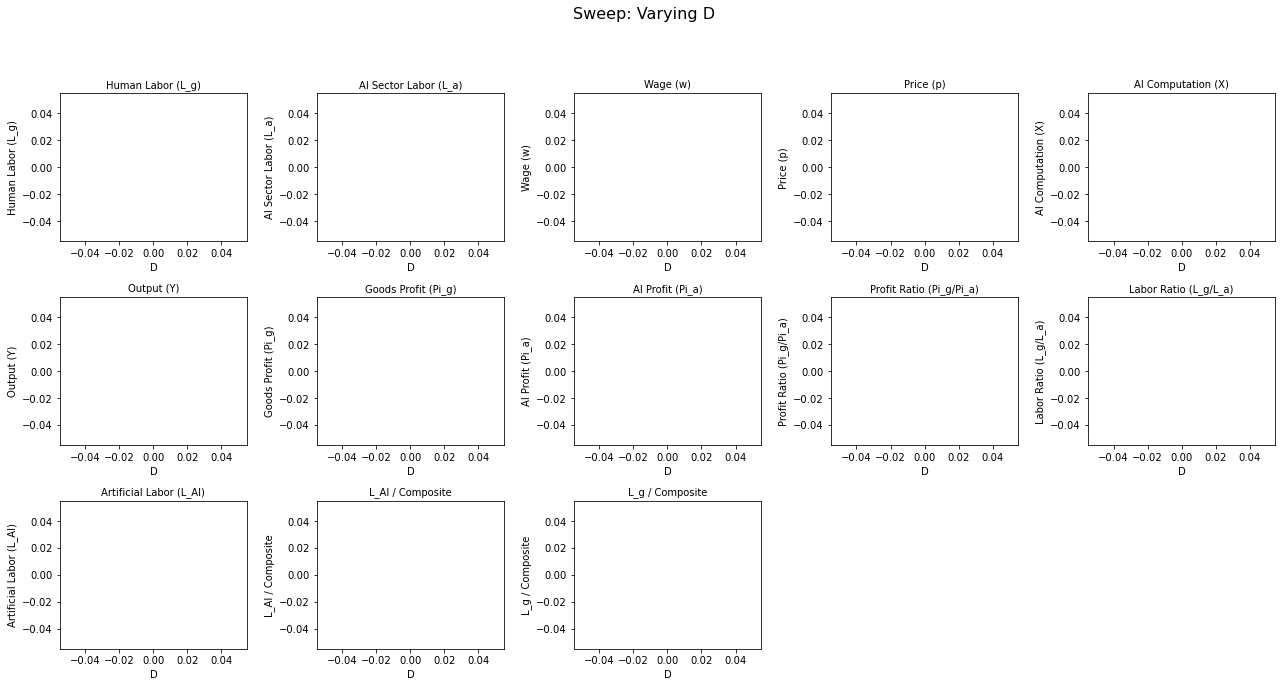

In [14]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

##############################################################################
# 1) Static AI Economy Model: Definitions & Solver
##############################################################################

def ai_equations(vars_, A, K_g, beta, gamma, iota, psi, K_a, alpha, Z, D, theta):
    """
    Computes the residuals of the 4-equation system describing the static equilibrium.
    
    Unknowns (in order):
      L_g  : human labor allocated to the general goods sector,
      L_a  : labor allocated to the AI sector,
      w    : wage rate,
      p    : price of AI computation services.
      
    Intermediate variables (defined as in your paper):
      - AI sector production: X = Z * K_a^alpha * L_a^(1-alpha)
      - Artificial labor (AI agent): 𝓛 = D^theta * X^(1-theta)
      - Composite labor in goods production: 
            L_comp = [iota * L_g^gamma + (1-iota) * 𝓛^gamma]^(1/gamma)
      - Output in the general goods sector: Y = A * K_g^beta * L_comp^(1-beta)
      
    The equilibrium conditions are:
      (1) FOC for L_g in the goods sector:
          A * K_g^beta * (1-beta) * iota * L_g^(gamma-1) * L_comp^(1-beta-gamma) - w = 0.
      (2) FOC for X in the goods sector:
          A * K_g^beta * (1-beta) * (1-iota) * (1-theta) *
          L_comp^(1-beta-gamma) * D^(theta*gamma) * X^((1-theta)*gamma - 1) - p = 0.
      (3) FOC for L_a in the AI sector:
          (1-alpha) * p * X / L_a - w = 0.
      (4) Labor market clearing:
          1 - L_g - L_a - psi*(Y/w) = 0.
    """
    L_g, L_a, w, p = vars_
    
    # AI sector production:
    X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))
    
    # Artificial labor (AI agent):
    L_AI = (D ** theta) * (X ** (1 - theta))
    
    # Composite labor in the general goods sector:
    composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
    
    # Output in the general goods sector:
    Y = A * (K_g ** beta) * (composite ** (1 - beta))
    
    # (1) FOC for L_g:
    eq1 = Y * (1 - beta) * iota * (L_g / composite) **  gamma /L_g - w
    
    # (2) FOC for X:
    # Note: (D^theta * X^(1-theta))^gamma = D^(theta*gamma)*X^((1-theta)*gamma)
    eq2 = (Y * (1 - beta) * (1 - iota) * (1 - theta) *
           (L_AI/composite )** (  gamma )/ X  - p)
    
    # (3) FOC for L_a in the AI sector:
    eq3 = (1 - alpha) * p * X / L_a - w
    
    # (4) Labor market clearing (household side):
    eq4 = 1 - L_g - L_a - psi * (Y / w)
    
    return np.array([eq1, eq2, eq3, eq4])


def solve_ai_model(
    alpha=0.5,    # AI sector exponent on capital
    theta=0.5,    # exponent for data in forming AI-labor
    gamma=0.1,    # substitution parameter between human and AI labor
    iota=0.5,     # weight on human labor in the composite labor input
    beta=0.3,     # exponent on capital in the general goods sector
    psi=1.0,      # leisure parameter (N = psi*(Y/w))
    A=1.0,        # TFP in the general goods sector
    K_g=6.0,     # Capital in the general goods sector
    Z=1.0,        # AI sector productivity
    K_a=1.0,      # Capital in the AI sector
    D=1.0,        # Data available for AI
    guess=(0.3, 0.3, 1.0, 1.0),
    method='hybr'
):
    """
    Solve the static model for the four unknowns: (L_g, L_a, w, p).
    
    Derived variables (computed after the solution):
      - AI sector production: X = Z*K_a^alpha*L_a^(1-alpha)
      - Artificial labor: L_AI = D^theta * X^(1-theta)
      - Composite labor: composite = [iota L_g^gamma + (1-iota) L_AI^gamma]^(1/gamma)
      - Goods output: Y = A*K_g^beta * composite^(1-beta)
      - Leisure: N = 1 - L_g - L_a   (which should equal psi*(Y/w) in equilibrium)
      - Profits:
           Pi_g = Y - w*L_g - p*X,
           Pi_a = p*X - w*L_a.
    """
    sol = root(
        ai_equations,
        guess,
        args=(A, K_g, beta, gamma, iota, psi, K_a, alpha, Z, D, theta),
        method=method
    )
    if not sol.success:
        raise RuntimeError(f"Solve failed: {sol.message}")
    
    L_g, L_a, w, p = sol.x
    
    # Recompute derived variables:
    X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))
    L_AI = (D ** theta) * (X ** (1 - theta))
    composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
    Y = A * (K_g ** beta) * (composite ** (1 - beta))
    N = 1 - L_g - L_a  # Note: in equilibrium, N should also equal psi*(Y/w)
    Pi_g = Y - w * L_g - p * X
    Pi_a = p * X - w * L_a
    
    return {
        'L_g': L_g,
        'L_a': L_a,
        'w': w,
        'p': p,
        'X': X,
        'L_AI': L_AI,
        'composite': composite,
        'Y': Y,
        'N': N,
        'Pi_g': Pi_g,
        'Pi_a': Pi_a
    }

##############################################################################
# 2) Parameter Sweep + Storage of ALL Variables and New Ratios
##############################################################################

def run_sweep(param_name, values, fixed_params):
    """
    For each value of the parameter 'param_name' in the array 'values', solve the model and
    store both the equilibrium variables and the following ratios:
      - ratio_of_profits = Pi_g / Pi_a,
      - ratio_of_labors  = L_g / L_a,
      - ratio_LAI        = L_AI / composite,
      - ratio_Lg         = L_g / composite.
    """
    all_keys = [
        'L_g', 'L_a', 'w', 'p', 'X', 'Y', 'Pi_g', 'Pi_a',
        'L_AI', 'composite', 'N',
        'ratio_of_profits',
        'ratio_of_labors',
        'ratio_LAI',
        'ratio_Lg'
    ]
    storage = {k: [] for k in all_keys}
    
    for val in values:
        params = dict(fixed_params)
        params[param_name] = val
        
        try:
            eq = solve_ai_model(**params)
        except Exception:
            # On failure, store NaN for all keys.
            for k in all_keys:
                storage[k].append(np.nan)
            continue
        
        # Compute ratio variables:
        ratio_of_profits = eq['Pi_g'] / eq['Pi_a'] if eq['Pi_a'] != 0 else np.nan
        ratio_of_labors  = eq['L_g'] / eq['L_a'] if eq['L_a'] != 0 else np.nan
        ratio_LAI = eq['L_AI'] / eq['composite'] if eq['composite'] != 0 else np.nan
        ratio_Lg  = eq['L_g'] / eq['composite'] if eq['composite'] != 0 else np.nan
        
        storage['L_g'].append(eq['L_g'])
        storage['L_a'].append(eq['L_a'])
        storage['w'].append(eq['w'])
        storage['p'].append(eq['p'])
        storage['X'].append(eq['X'])
        storage['Y'].append(eq['Y'])
        storage['Pi_g'].append(eq['Pi_g'])
        storage['Pi_a'].append(eq['Pi_a'])
        storage['L_AI'].append(eq['L_AI'])
        storage['composite'].append(eq['composite'])
        storage['N'].append(eq['N'])
        storage['ratio_of_profits'].append(ratio_of_profits)
        storage['ratio_of_labors'].append(ratio_of_labors)
        storage['ratio_LAI'].append(ratio_LAI)
        storage['ratio_Lg'].append(ratio_Lg)
    
    # Convert lists to numpy arrays.
    for k in storage:
        storage[k] = np.array(storage[k], dtype=float)
    
    return storage

##############################################################################
# 3) Plot Function: 13 Subplots in a Single Figure (3x5 grid; last 2 hidden)
##############################################################################

def plot_sweep_subplots(x_vals, results, x_label, title_prefix):
    """
    Create one figure with subplots for 13 variables:
      1. L_g
      2. L_a
      3. w
      4. p
      5. X
      6. Y
      7. Pi_g
      8. Pi_a
      9. ratio_of_profits (Pi_g / Pi_a)
      10. ratio_of_labors  (L_g / L_a)
      11. L_AI
      12. ratio_LAI (L_AI / composite)
      13. ratio_Lg  (L_g / composite)
      
    The layout is on a 3x5 grid; the extra subplots are hidden.
    """
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    fig.suptitle(title_prefix, fontsize=16)
    
    plot_list = [
        ('L_g',            "Human Labor (L_g)"),
        ('L_a',            "AI Sector Labor (L_a)"),
        ('w',              "Wage (w)"),
        ('p',              "Price (p)"),
        ('X',              "AI Computation (X)"),
        ('Y',              "Output (Y)"),
        ('Pi_g',           "Goods Profit (Pi_g)"),
        ('Pi_a',           "AI Profit (Pi_a)"),
        ('ratio_of_profits',"Profit Ratio (Pi_g/Pi_a)"),
        ('ratio_of_labors',"Labor Ratio (L_g/L_a)"),
        ('L_AI',           "Artificial Labor (L_AI)"),
        ('ratio_LAI',      "L_AI / Composite"),
        ('ratio_Lg',       "L_g / Composite"),
    ]
    
    idx = 0
    for row in range(3):
        for col in range(5):
            if idx < len(plot_list):
                key, ylabel = plot_list[idx]
                ax = axes[row, col]
                ax.plot(x_vals, results[key], 'o-')
                ax.set_xlabel(x_label)
                ax.set_ylabel(ylabel)
                ax.set_title(ylabel, fontsize=10)
                idx += 1
            else:
                # Hide any extra subplots.
                axes[row, col].set_visible(False)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

##############################################################################
# 4) MAIN: Sweeps for gamma, Z, and D (each produces one big figure)
##############################################################################

if __name__ == "__main__":
    # Base calibration parameters
    base_params = {
        'alpha': 0.5,
        'theta': 0.5,
        'gamma': 0.1,
        'iota': 0.5,
        'beta': 0.3,
        'psi': 1.0,
        'A': 1.0,
        'K_g': 5.0,
        'Z': 1.0,
        'K_a': 1.0,
        'D': 1.0,
        'guess': (0.3, 0.3, 1.0, 1.0)
    }
    
    # 1) Sweep gamma from 0.01 to 0.9
    gamma_vals = np.linspace(0.01, 0.9, 20)
    res_gamma = run_sweep('gamma', gamma_vals, base_params)
    plot_sweep_subplots(gamma_vals, res_gamma, r"$\gamma$", "Sweep: Varying $\gamma$")
    
    # 2) Sweep Z (AI sector productivity) from 1.0 to 5.0
    Z_vals = np.linspace(1.0, 5.0, 20)
    res_Z = run_sweep('Z', Z_vals, base_params)
    plot_sweep_subplots(Z_vals, res_Z, "Z", "Sweep: Varying Z")
    
    # 3) Sweep D (data availability) from 1.0 to 10.0
    D_vals = np.linspace(1.0, 10.0, 20)
    res_D = run_sweep('D', D_vals, base_params)
    plot_sweep_subplots(D_vals, res_D, "D", "Sweep: Varying D")


<ipython-input-76-942f0b7de87c>:45: RuntimeWarning: invalid value encountered in scalar power
  composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)


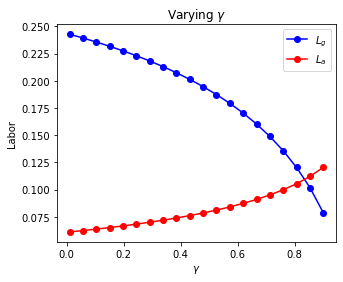

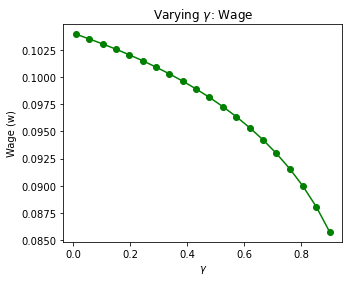

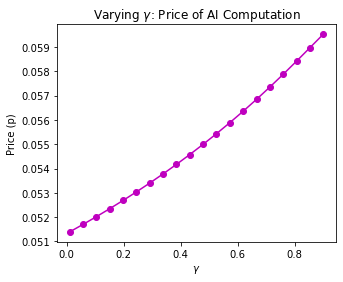

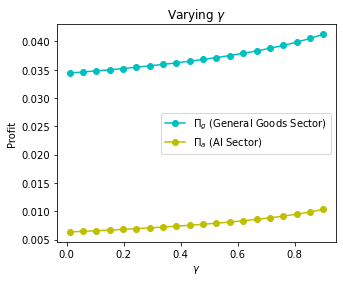

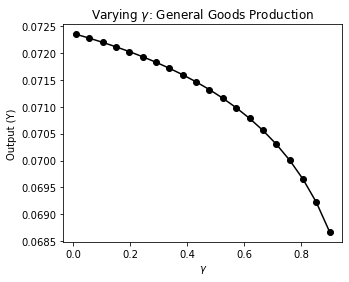

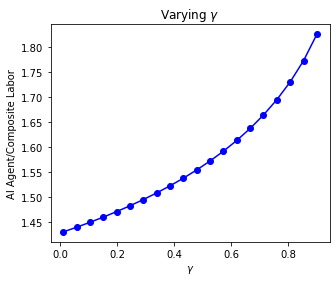

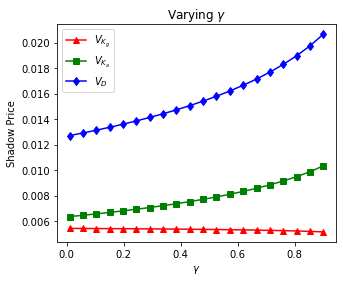

In [76]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

##############################################################################
# 1) Static AI Economy Model: Definitions & Solver with Revised FOCs
##############################################################################

def ai_equations(vars_, A, K_g, beta, gamma, iota, psi, K_a, alpha, Z, D, theta):
    """
    Computes the residuals of the 4-equation system describing the static equilibrium.
    
    Unknowns (in order):
      L_g  : Human labor in the general goods sector.
      L_a  : Labor in the AI sector.
      w    : Wage.
      p    : Price of AI computation.
      
    Intermediate variables:
      - AI sector production: X = Z * K_a^alpha * L_a^(1-alpha)
      - Artificial labor: L_AI = D^theta * X^(1-theta)
      - Composite labor (used in goods production): 
            composite = [iota * L_g^gamma + (1-iota) * L_AI^gamma]^(1/gamma)
      - General goods output: Y = A * K_g^beta * composite^(1-beta)
      
    Equilibrium conditions:
      (1) FOC for L_g:
          Y*(1-beta)*iota*(L_g/composite)^gamma / L_g - w = 0.
      (2) FOC for X:
          Y*(1-beta)*(1-iota)*(1-theta)*(L_AI/composite)^gamma / X - p = 0.
      (3) FOC for L_a in the AI sector:
          (1-alpha)*p*X/L_a - w = 0.
      (4) Labor market clearing:
          1 - L_g - L_a - psi*(Y/w) = 0.
    """
    L_g, L_a, w, p = vars_
    
    # AI sector production:
    X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))
    
    # Artificial labor (the AI agent):
    L_AI = (D ** theta) * (X ** (1 - theta))
    
    # Composite labor used in general goods production:
    composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
    
    # Output in the general goods sector:
    Y = A * (K_g ** beta) * (composite ** (1 - beta))
    
    # (1) FOC for human labor L_g:
    eq1 = Y * (1 - beta) * iota * (L_g / composite) ** gamma / L_g - w
    
    # (2) FOC for computation X:
    eq2 = Y * (1 - beta) * (1 - iota) * (1 - theta) * (L_AI / composite) ** gamma / X - p
    
    # (3) FOC for AI sector labor L_a:
    eq3 = (1 - alpha) * p * X / L_a - w
    
    # (4) Labor market clearing (including leisure):
    eq4 = 1 - L_g - L_a - psi * (Y / w)
    
    return np.array([eq1, eq2, eq3, eq4])


def solve_ai_model(
    alpha=0.5,    # Exponent on capital in the AI sector.
    theta=0.5,    # Exponent for data in forming AI-labor.
    gamma=0.1,    # Substitution parameter (elasticity) between human and AI labor.
    iota=0.5,     # Weight on human labor in the composite labor input.
    beta=0.3,     # Exponent on capital in the general goods sector.
    psi=1.0,      # Leisure parameter (N = psi*(Y/w)).
    A=1.0,        # TFP in the general goods sector.
    K_g=10.0,     # Capital in the general goods sector.
    Z=1.0,        # Productivity in the AI sector.
    K_a=1.0,      # Capital in the AI sector.
    D=1.0,        # Data available for AI.
    guess=(0.3, 0.3, 1.0, 1.0),
    method='hybr'
):
    """
    Solve the static model for the unknowns: (L_g, L_a, w, p). Also computes derived variables:
      - X: AI sector production.
      - L_AI: Artificial labor.
      - composite: Composite labor input.
      - Y: Output in the general goods sector.
      - N: Leisure.
      - Profits: Pi_g and Pi_a.
      - Shadow prices: V_Kg, V_Ka, and V_D.
    """
    sol = root(
        ai_equations,
        guess,
        args=(A, K_g, beta, gamma, iota, psi, K_a, alpha, Z, D, theta),
        method=method
    )
    if not sol.success:
        raise RuntimeError(f"Solve failed: {sol.message}")
    
    L_g, L_a, w, p = sol.x
    
    # Recompute intermediate variables:
    X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))
    L_AI = (D ** theta) * (X ** (1 - theta))
    composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
    Y = A * (K_g ** beta) * (composite ** (1 - beta))
    N = 1 - L_g - L_a  # (Should equal psi*(Y/w) in equilibrium.)
    
    # Profits:
    Pi_g = Y - w * L_g - p * X
    Pi_a = p * X - w * L_a
    
    # Shadow prices:
    V_Kg = beta * Y / K_g
    V_Ka = alpha * p * X / K_a
    V_D  = (1 - beta) * (1 - iota) * theta * (L_AI / composite) ** gamma * Y / D
    
    return {
        'L_g': L_g,
        'L_a': L_a,
        'w': w,
        'p': p,
        'X': X,
        'L_AI': L_AI,
        'composite': composite,
        'Y': Y,
        'N': N,
        'Pi_g': Pi_g,
        'Pi_a': Pi_a,
        'V_Kg': V_Kg,
        'V_Ka': V_Ka,
        'V_D': V_D
    }

##############################################################################
# 2) Parameter Sweep: Storing All Variables and Derived Ratios/Prices
##############################################################################

def run_sweep(param_name, values, fixed_params):
    """
    For each value in 'values' (for the parameter 'param_name'),
    solve the model and store the following variables:
      - L_g, L_a, w, p, X, Y, Pi_g, Pi_a, L_AI, composite, N
      - Shadow prices: V_Kg, V_Ka, V_D
      - Additionally, store the ratio: L_AI/composite.
    """
    keys = ['L_g', 'L_a', 'w', 'p', 'X', 'Y', 'Pi_g', 'Pi_a', 
            'L_AI', 'composite', 'N', 'V_Kg', 'V_Ka', 'V_D', 'ratio_LAI']
    storage = {k: [] for k in keys}
    
    for val in values:
        params = dict(fixed_params)
        params[param_name] = val
        
        try:
            eq = solve_ai_model(**params)
        except Exception:
            for k in keys:
                storage[k].append(np.nan)
            continue
        
        # Ratio of AI labor over composite labor:
        ratio_LAI = eq['L_AI'] / eq['composite'] if eq['composite'] != 0 else np.nan
        
        storage['L_g'].append(eq['L_g'])
        storage['L_a'].append(eq['L_a'])
        storage['w'].append(eq['w'])
        storage['p'].append(eq['p'])
        storage['X'].append(eq['X'])
        storage['Y'].append(eq['Y'])
        storage['Pi_g'].append(eq['Pi_g'])
        storage['Pi_a'].append(eq['Pi_a'])
        storage['L_AI'].append(eq['L_AI'])
        storage['composite'].append(eq['composite'])
        storage['N'].append(eq['N'])
        storage['V_Kg'].append(eq['V_Kg'])
        storage['V_Ka'].append(eq['V_Ka'])
        storage['V_D'].append(eq['V_D'])
        storage['ratio_LAI'].append(ratio_LAI)
        
    # Convert lists to numpy arrays.
    for k in storage:
        storage[k] = np.array(storage[k], dtype=float)
    
    return storage

##############################################################################
# 3) Custom Plotting: Separate Figures for Selected Variables
##############################################################################

def custom_plots(x_vals, results, x_label, title_prefix):
    """
    Creates separate figures for:
      1. Both labors L_g and L_a.
      2. Wage w.
      3. Price of AI computation p.
      4. Profits of the two sectors: Pi_g and Pi_a.
      5. General goods production Y.
      6. Ratio of AI labor over composite: L_AI/composite.
      7. Shadow prices: V_Kg, V_Ka, V_D.
    """
    # Figure 1: Both labors in one figure.
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['L_g'], 'bo-', label=r'$L_g$')
    plt.plot(x_vals, results['L_a'], 'ro-', label=r'$L_a$')
    plt.xlabel(x_label)
    plt.ylabel("Labor")
    plt.title(f"{title_prefix}")
    plt.legend()
    
    # Figure 2: Wage
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['w'], 'go-')
    plt.xlabel(x_label)
    plt.ylabel("Wage (w)")
    plt.title(f"{title_prefix}: Wage")
    
    # Figure 3: Price of AI computation
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['p'], 'mo-')
    plt.xlabel(x_label)
    plt.ylabel("Price (p)")
    plt.title(f"{title_prefix}: Price of AI Computation")
    
    # Figure 4: Profits of the two sectors
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['Pi_g'], 'co-', label=r'$\Pi_g$ (General Goods Sector)')
    plt.plot(x_vals, results['Pi_a'], 'yo-', label=r'$\Pi_a$ (AI Sector)')
    plt.xlabel(x_label)
    plt.ylabel("Profit")
    plt.title(f"{title_prefix}")
    plt.legend()
    
    # Figure 5: General goods production Y
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['Y'], 'ko-')
    plt.xlabel(x_label)
    plt.ylabel("Output (Y)")
    plt.title(f"{title_prefix}: General Goods Production")
    
    # Figure 6: Ratio of AI labor over composite labor: L_AI / composite
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['ratio_LAI'], 'bo-')
    plt.xlabel(x_label)
    plt.ylabel(r"AI Agent/Composite Labor")
    plt.title(f"{title_prefix}")
    
    # Figure 7: Shadow prices: V_Kg, V_Ka, and V_D
    plt.figure(figsize=(5, 4))
    plt.plot(x_vals, results['V_Kg'], 'r^-', label=r'$V_{K_g}$')
    plt.plot(x_vals, results['V_Ka'], 's-', color='green', label=r'$V_{K_a}$')
    plt.plot(x_vals, results['V_D'], 'd-', color='blue', label=r'$V_D$')
    plt.xlabel(x_label)
    plt.ylabel("Shadow Price")
    plt.title(f"{title_prefix}")
    plt.legend()
    
    plt.show()

##############################################################################
# 4) MAIN: Sweep Over a Parameter and Plot the Results
##############################################################################

if __name__ == "__main__":
    # Base calibration parameters (you can modify these as needed)
    base_params = {
        'alpha': 0.5,
        'theta': 0.5,
        'gamma': 0.2,   # This will be varied in the sweep below.
        'iota': 0.5,
        'beta': 0.3,
        'psi': 1.0,
        'A': .1 ,
        'K_g': 4.0,
        'Z': 1.0,
        'K_a': 1.0,
        'D': 1.0,
        'guess': (0.3, 0.3, 1.0, 1.0)
    }
    
    # Example: Sweep gamma from 0.01 to 0.9.
    gamma_vals = np.linspace(0.01, 0.9, 20)
    res_gamma = run_sweep('gamma', gamma_vals, base_params)
    custom_plots(gamma_vals, res_gamma, r"$\gamma$", "Varying $\gamma$")
    
 

<ipython-input-76-942f0b7de87c>:45: RuntimeWarning: invalid value encountered in scalar power
  composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
<ipython-input-76-942f0b7de87c>:39: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


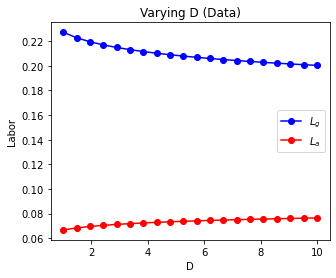

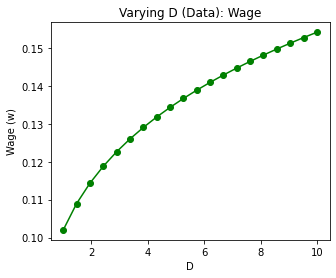

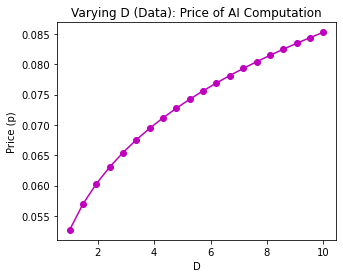

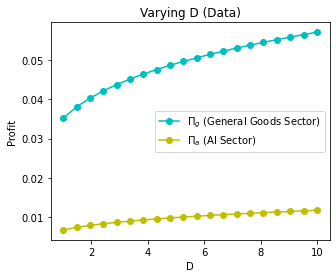

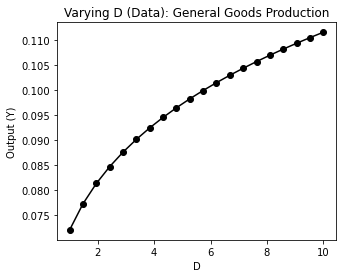

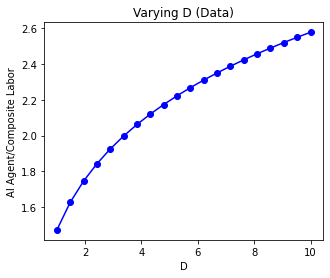

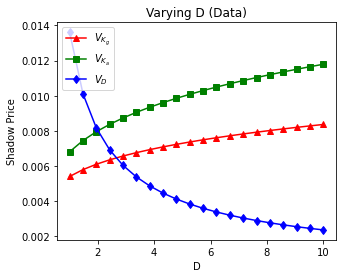

In [77]:
    # 1. Sweep D (Data availability)
    D_vals = np.linspace(1.0, 10.0, 20)
    res_D = run_sweep('D', D_vals, base_params)
    custom_plots(D_vals, res_D, 'D', 'Varying D (Data)')
    

<ipython-input-76-942f0b7de87c>:45: RuntimeWarning: invalid value encountered in scalar power
  composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
<ipython-input-76-942f0b7de87c>:39: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


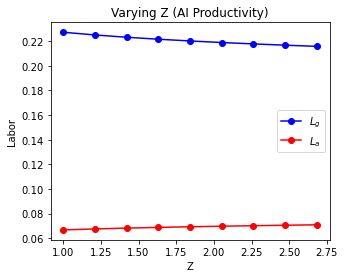

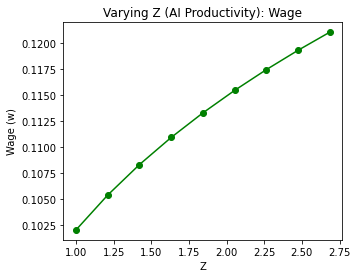

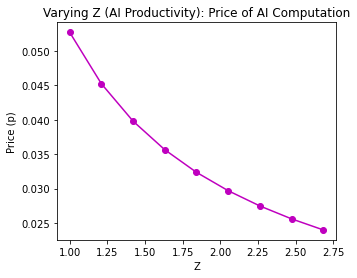

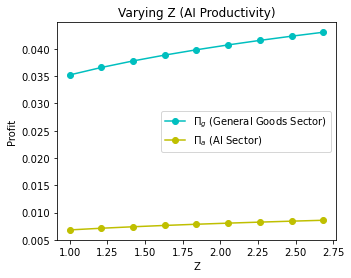

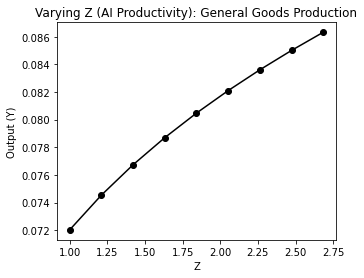

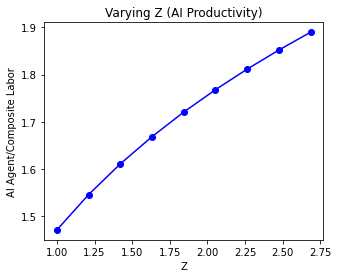

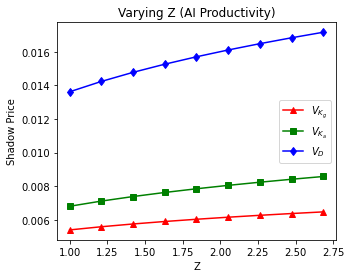

In [78]:
 
    # 3. Sweep Z (AI sector productivity)
    Z_vals = np.linspace(1.0, 5.0, 20)
    res_Z = run_sweep('Z', Z_vals, base_params)
    custom_plots(Z_vals, res_Z, 'Z', 'Varying Z (AI Productivity)')
    
 
   

<ipython-input-76-942f0b7de87c>:45: RuntimeWarning: invalid value encountered in scalar power
  composite = (iota * (L_g ** gamma) + (1 - iota) * (L_AI ** gamma)) ** (1 / gamma)
<ipython-input-76-942f0b7de87c>:39: RuntimeWarning: invalid value encountered in scalar power
  X = Z * (K_a ** alpha) * (L_a ** (1 - alpha))


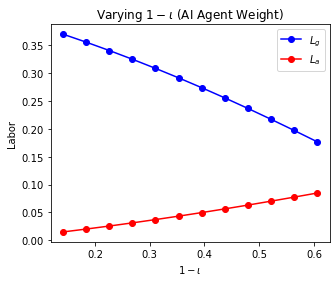

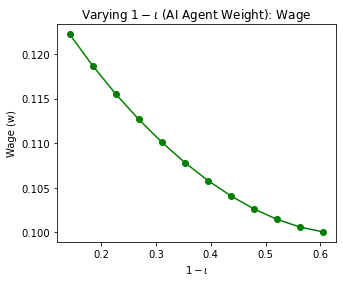

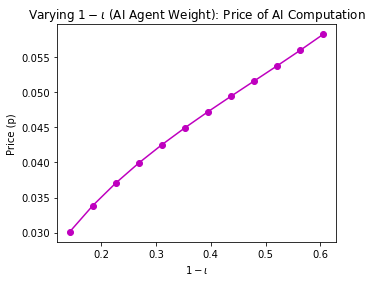

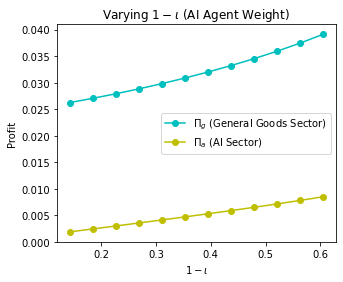

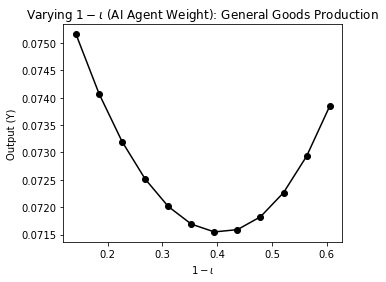

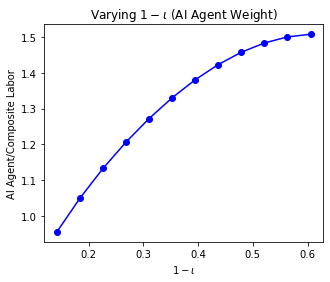

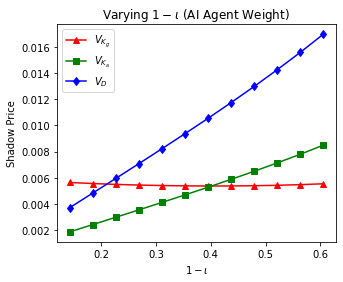

In [79]:
# 4. Sweep over different values of 1 - iota.
one_minus_iota_vals = np.linspace(0.1, 0.9, 20)
# Compute corresponding iota values:
iota_vals = 1 - one_minus_iota_vals

# Run the sweep using the computed iota values.
res_iota = run_sweep('iota', iota_vals, base_params)

# Plot the results with the x-axis showing 1 - iota.
custom_plots(one_minus_iota_vals, res_iota, r'$1-\iota$', 'Varying $1-\iota$ (AI Agent Weight)')
